#0- Imports

In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from balancer import check_class_distribution, plot_class_distribution, apply_data_balancing
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from feature_engineering import TfidfVectorizer, extract_basic_features, feature_engineering_pipeline, CountVectorizer
from text_preprocessing import preprocess_dataset, preprocess_text

ModuleNotFoundError: No module named 'balancer'

#1- Data

In [ ]:
# Load your dataset
data = pd.read_csv('scitweets_export.tsv', sep='\t')
print("this is first")
data.head()
# Apply preprocessing on the dataset


this is first


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


#2- Metrics Evaluation function

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance with multiple metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    print(f"\n=== {model_name} Performance ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ['Non-Scientific', 'Scientific'])
    plt.yticks(tick_marks, ['Non-Scientific', 'Scientific'])

    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.close()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


#2- Prediction Function

In [ ]:
def predict_scientific(text, model, preprocessor=None, vectorizer=None, feature_extractor=None):
    """Predict if a text is scientific based on the trained model."""
    if preprocessor:
        text = preprocessor(text)

    if vectorizer and not feature_extractor:
        # TF-IDF vectorization only
        features = vectorizer.transform([text])
        prediction = model.predict(features)
        proba = model.predict_proba(features)[0][1]
    elif feature_extractor and not vectorizer:
        # Feature engineering only
        text_df = pd.DataFrame({'text': [text]})
        features_df = feature_extractor(text_df)
        # Drop text columns to keep only numeric features
        features_df = features_df.drop(columns=['text'])
        prediction = model.predict(features_df)
        proba = model.predict_proba(features_df)[0][1]
    else:
        # Default simple prediction
        prediction = [0]
        proba = 0

    return prediction[0], proba

#3- Loading the dataset

In [ ]:
print("Loading dataset...")
try:
    df = pd.read_csv('scitweets_export.tsv', sep='\t')
except FileNotFoundError:
    print("Dataset file not found. Please ensure 'scitweets_export.tsv' is in the correct location.")
    exit(1)

print(f"Dataset loaded: {df.shape[0]} rows and {df.shape[1]} columns")
print("Sample data:")
print(df.head())


Loading dataset...
Dataset loaded: 1140 rows and 7 columns
Sample data:
   Unnamed: 0            tweet_id  \
0           0  316669998137483264   
1           1  319090866545385472   
2           2  322030931022065664   
3           3  322694830620807168   
4           4  328524426658328576   

                                                text  science_related  \
0  Knees are a bit sore. i guess that's a sign th...                0   
1          McDonald's breakfast stop then the gym 🏀💪                0   
2  Can any Gynecologist with Cancer Experience ex...                1   
3  Couch-lock highs lead to sleeping in the couch...                1   
4  Does daily routine help prevent problems with ...                1   

   scientific_claim  scientific_reference  scientific_context  
0               0.0                   0.0                 0.0  
1               0.0                   0.0                 0.0  
2               1.0                   0.0                 0.0  
3         

#4- Classification binaire : SCI vs. NON-SCI

##4.1- Check target variable and distribution

In [ ]:
target_col = 'science_related'
print(f"\nTarget variable '{target_col}' distribution:")
original_class_counts = check_class_distribution(df[target_col])
plot_class_distribution(original_class_counts, "Original Dataset Class Distribution")



Target variable 'science_related' distribution:
Class distribution:
Class 0: 765 samples (67.11%)
Class 1: 375 samples (32.89%)


##4.2- Prepare for different experiments

In [ ]:
X = df['text']
y = df[target_col]

# Split data once to ensure consistent evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nSplit data into training ({len(X_train)} samples) and testing ({len(X_test)} samples) sets.")


results = {}


Split data into training (912 samples) and testing (228 samples) sets.


##4.3- Experiment 1: Baseline with no preprocessing, feature engineering, or balancing


--- Experiment 1: Baseline Model ---


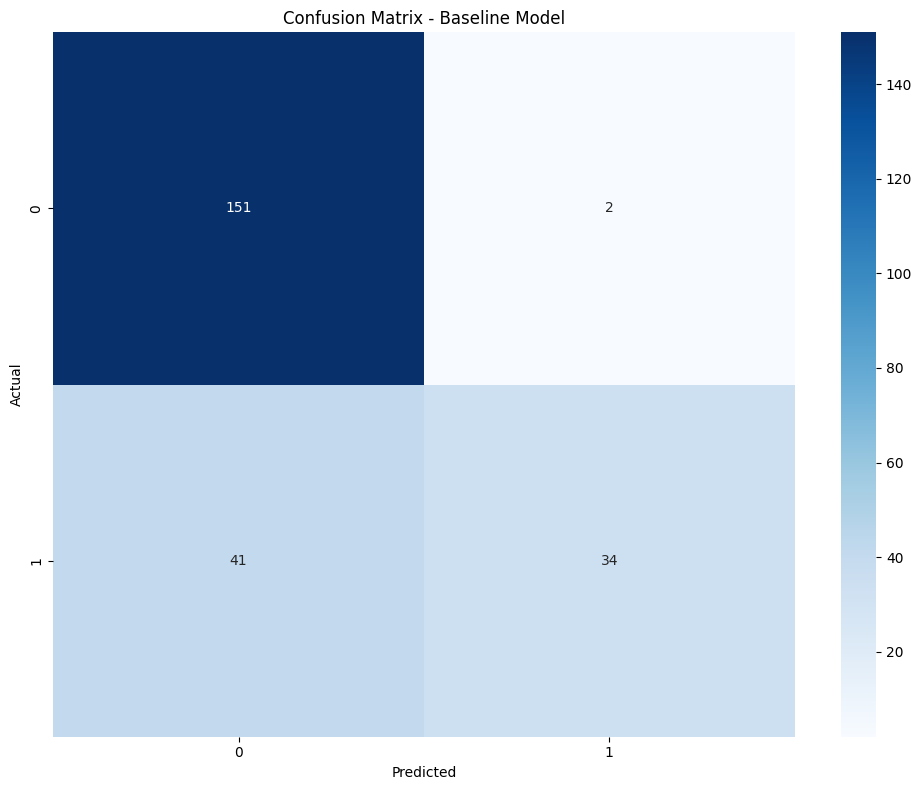


=== Baseline Model Performance ===
Accuracy: 0.8114
Precision: 0.9444
Recall: 0.4533
F1 Score: 0.6126

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       153
           1       0.94      0.45      0.61        75

    accuracy                           0.81       228
   macro avg       0.87      0.72      0.74       228
weighted avg       0.84      0.81      0.79       228


Confusion Matrix:
[[151   2]
 [ 41  34]]


In [ ]:
print("\n--- Experiment 1: Baseline Model ---")

# Simple TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train logistic regression
model_baseline = LogisticRegression(max_iter=1000, random_state=42)
model_baseline.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_baseline = model_baseline.predict(X_test_tfidf)

# Display confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_baseline)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=model_baseline.classes_,
           yticklabels=model_baseline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Baseline Model')
plt.tight_layout()
plt.show()

# Store results
results['Baseline'] = evaluate_model(y_test, y_pred_baseline, "Baseline Model")

# Store confusion matrix in results dictionary for later comparison
if 'Baseline' in results:
    results['Baseline']['confusion_matrix'] = cm
    results['Baseline']['classes'] = model_baseline.classes_

##4.4- Experiment 2: With text preprocessing only


--- Experiment 2: Preprocessing Only ---
Preprocessing texts...


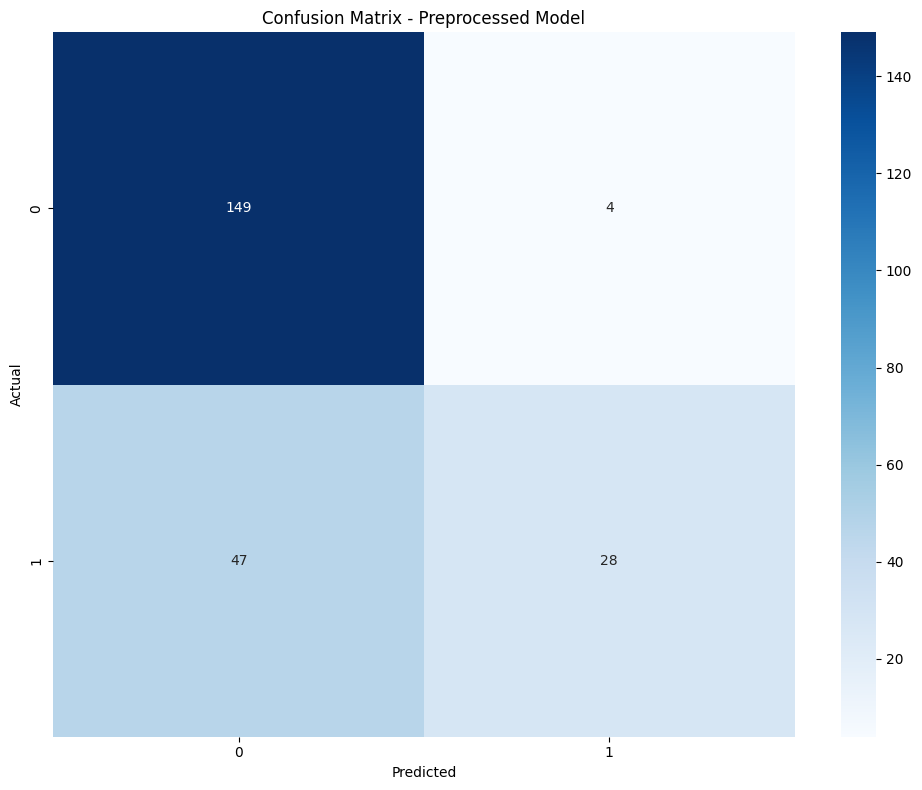


=== Preprocessed Model Performance ===
Accuracy: 0.7763
Precision: 0.8750
Recall: 0.3733
F1 Score: 0.5234

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       153
           1       0.88      0.37      0.52        75

    accuracy                           0.78       228
   macro avg       0.82      0.67      0.69       228
weighted avg       0.80      0.78      0.75       228


Confusion Matrix:
[[149   4]
 [ 47  28]]


In [ ]:
print("\n--- Experiment 2: Preprocessing Only ---")
#preprocess data
print("Preprocessing texts...")
df_train_processed = preprocess_dataset(pd.DataFrame({'text': X_train}))
df_test_processed = preprocess_dataset(pd.DataFrame({'text': X_test}))

#TF-IDF on preprocessed text
tfidf_preprocessed = TfidfVectorizer(max_features=1000)
X_train_tfidf_prep = tfidf_preprocessed.fit_transform(df_train_processed['text_processed'])
X_test_tfidf_prep = tfidf_preprocessed.transform(df_test_processed['text_processed'])

#train logistic regression
model_preprocessed = LogisticRegression(max_iter=1000, random_state=42)
model_preprocessed.fit(X_train_tfidf_prep, y_train)

# Evaluate
y_pred_preprocessed = model_preprocessed.predict(X_test_tfidf_prep)

# Generate confusion matrix
cm_preprocessed = confusion_matrix(y_test, y_pred_preprocessed)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_preprocessed, annot=True, fmt='d', cmap='Blues',
           xticklabels=model_preprocessed.classes_,
           yticklabels=model_preprocessed.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Preprocessed Model')
plt.tight_layout()
plt.show()

# Store results
results['Preprocessing'] = evaluate_model(y_test, y_pred_preprocessed, "Preprocessed Model")

# Store confusion matrix in results dictionary for later comparison
if 'Preprocessing' in results:
    results['Preprocessing']['confusion_matrix'] = cm_preprocessed
    results['Preprocessing']['classes'] = model_preprocessed.classes_

##4.5- Experiment 3: With feature engineering only


--- Experiment 3: Feature Engineering Only ---
Extracting features...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


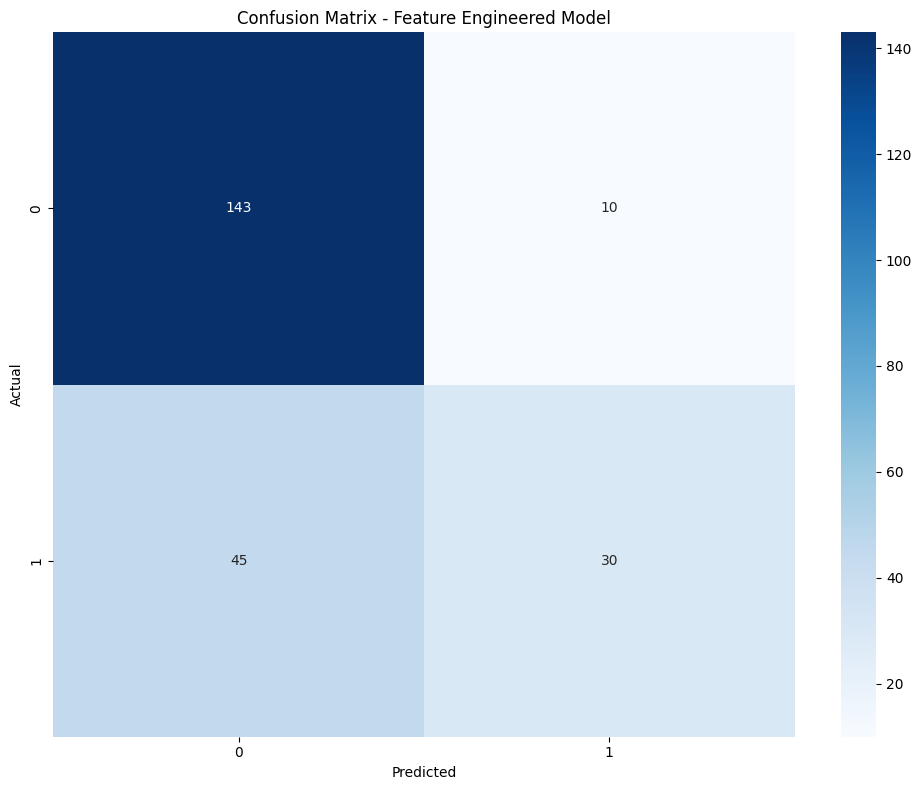


=== Feature Engineered Model Performance ===
Accuracy: 0.7588
Precision: 0.7500
Recall: 0.4000
F1 Score: 0.5217

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       153
           1       0.75      0.40      0.52        75

    accuracy                           0.76       228
   macro avg       0.76      0.67      0.68       228
weighted avg       0.76      0.76      0.73       228


Confusion Matrix:
[[143  10]
 [ 45  30]]


In [ ]:
print("\n--- Experiment 3: Feature Engineering Only ---")

#create feature-engineered datasets
print("Extracting features...")
df_train_features = extract_basic_features(pd.DataFrame({'text': X_train}))
df_test_features = extract_basic_features(pd.DataFrame({'text': X_test}))

#drop text column to keep only numeric features
feature_cols = [col for col in df_train_features.columns if col != 'text']
X_train_features = df_train_features[feature_cols]
X_test_features = df_test_features[feature_cols]

#train logistic regression
model_features = LogisticRegression(max_iter=1000, random_state=42)
model_features.fit(X_train_features, y_train)

# Evaluate
y_pred_features = model_features.predict(X_test_features)

# Generate confusion matrix
cm_features = confusion_matrix(y_test, y_pred_features)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_features, annot=True, fmt='d', cmap='Blues',
           xticklabels=model_features.classes_,
           yticklabels=model_features.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Feature Engineered Model')
plt.tight_layout()
plt.show()

# Store results and confusion matrix
results['Feature Engineering'] = evaluate_model(y_test, y_pred_features, "Feature Engineered Model")

# Store confusion matrix in results dictionary for later comparison
if 'Feature Engineering' in results:
    results['Feature Engineering']['confusion_matrix'] = cm_features
    results['Feature Engineering']['classes'] = model_features.classes_

##4.6- Experiment 4: With balancing only


--- Experiment 4: Balancing Only ---
Applying smote balancing...
Original dataset shape: Counter({0: 612, 1: 300})
Resampled dataset shape: Counter({0: 612, 1: 612})


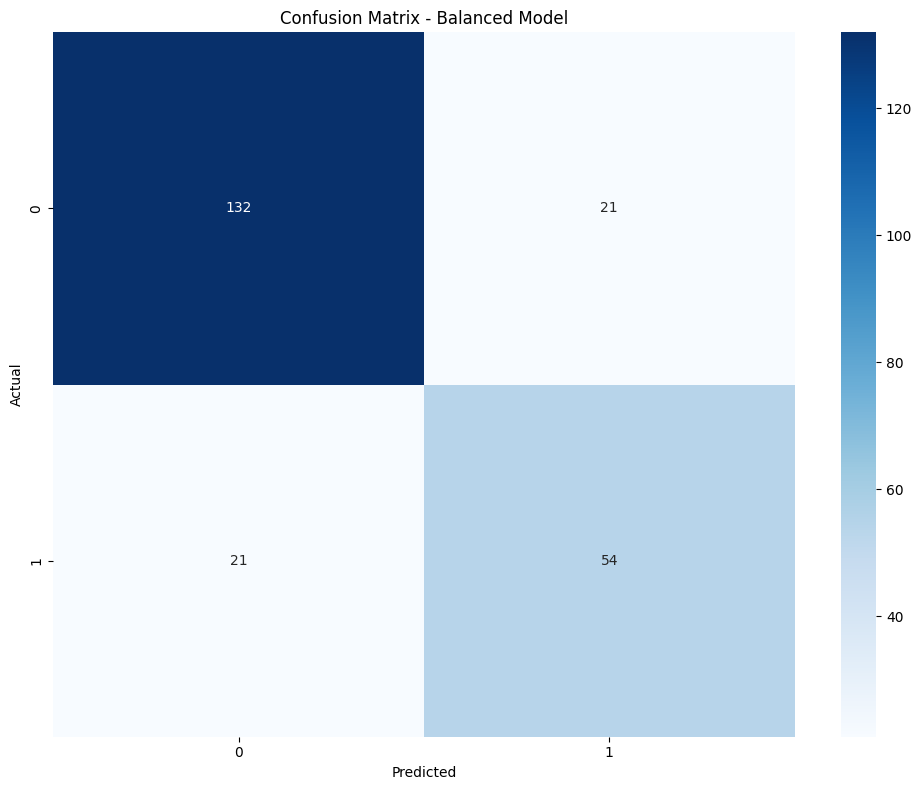


=== Balanced Model Performance ===
Accuracy: 0.8158
Precision: 0.7200
Recall: 0.7200
F1 Score: 0.7200

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       153
           1       0.72      0.72      0.72        75

    accuracy                           0.82       228
   macro avg       0.79      0.79      0.79       228
weighted avg       0.82      0.82      0.82       228


Confusion Matrix:
[[132  21]
 [ 21  54]]


In [ ]:
print("\n--- Experiment 4: Balancing Only ---")

# Apply SMOTE balancing on TF-IDF features
X_train_tfidf_balanced, y_train_balanced = apply_data_balancing(
    X_train_tfidf.toarray(), y_train, method='smote', random_state=42
)

# Train logistic regression
model_balanced = LogisticRegression(max_iter=1000, random_state=42)
model_balanced.fit(X_train_tfidf_balanced, y_train_balanced)

# Evaluate on original test set
y_pred_balanced = model_balanced.predict(X_test_tfidf)

# Generate confusion matrix
cm_balanced = confusion_matrix(y_test, y_pred_balanced)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues',
           xticklabels=model_balanced.classes_,
           yticklabels=model_balanced.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Balanced Model')
plt.tight_layout()
plt.show()

# Store results and confusion matrix
results['Balancing'] = evaluate_model(y_test, y_pred_balanced, "Balanced Model")

# Store confusion matrix in results dictionary for later comparison
if 'Balancing' in results:
    results['Balancing']['confusion_matrix'] = cm_balanced
    results['Balancing']['classes'] = model_balanced.classes_

##4.7- Experiment 5: With all techniques combined


--- Experiment 5: All Techniques Combined ---
Combining all techniques...
Applying smote balancing...
Original dataset shape: Counter({0: 612, 1: 300})
Resampled dataset shape: Counter({0: 612, 1: 612})


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


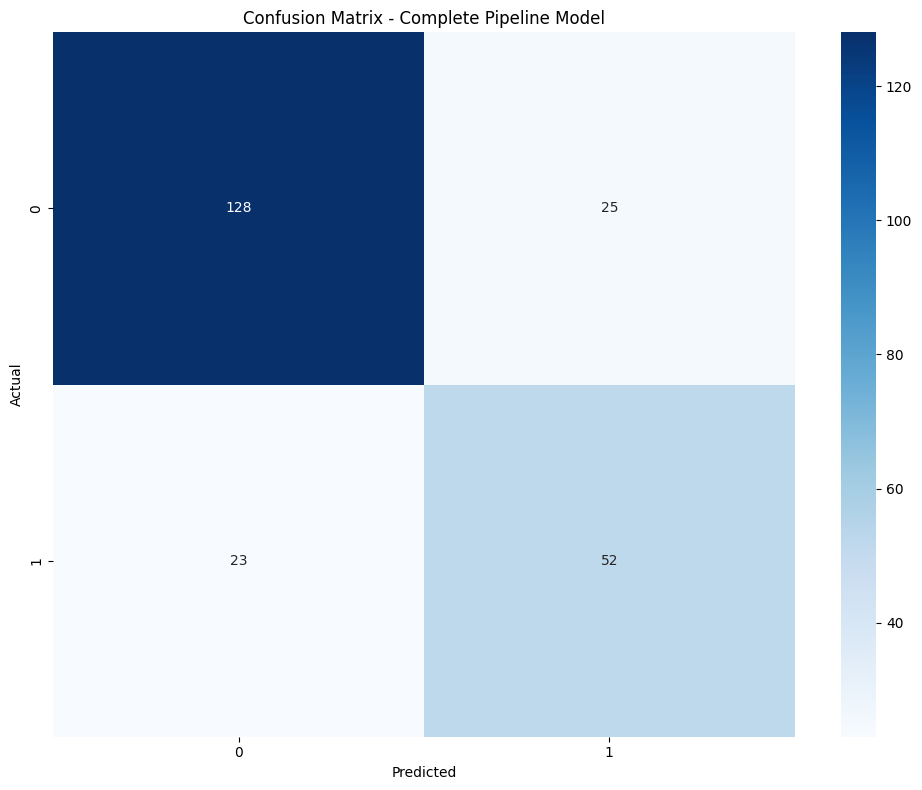


=== Complete Pipeline Model Performance ===
Accuracy: 0.7895
Precision: 0.6753
Recall: 0.6933
F1 Score: 0.6842

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       153
           1       0.68      0.69      0.68        75

    accuracy                           0.79       228
   macro avg       0.76      0.76      0.76       228
weighted avg       0.79      0.79      0.79       228


Confusion Matrix:
[[128  25]
 [ 23  52]]


In [ ]:
print("\n--- Experiment 5: All Techniques Combined ---")

# Preprocess + Feature Engineering
print("Combining all techniques...")

# First preprocess
df_train_processed = preprocess_dataset(pd.DataFrame({'text': X_train}))
df_test_processed = preprocess_dataset(pd.DataFrame({'text': X_test}))

# Then apply feature engineering
df_train_all, train_vectorizer = feature_engineering_pipeline(df_train_processed, text_column='text_processed')

# For test set, use the vectorizer from training
df_test_all = extract_basic_features(df_test_processed, text_column='text_processed')
test_tfidf_features = train_vectorizer.transform(df_test_processed['text_processed'])

# Add TF-IDF features to test dataframe
tfidf_test_df = pd.DataFrame(
    test_tfidf_features.toarray(),
    columns=[f'tfidf_{i}' for i in range(test_tfidf_features.shape[1])],
    index=df_test_all.index
)
df_test_all = pd.concat([df_test_all, tfidf_test_df], axis=1)

# Drop text columns
feature_cols = [col for col in df_train_all.columns
               if col not in ['text', 'text_processed']]
X_train_all = df_train_all[feature_cols]
X_test_all = df_test_all[feature_cols]

# Apply balancing
X_train_all_balanced, y_train_all_balanced = apply_data_balancing(
    X_train_all.values, y_train, method='smote', random_state=42
)

# Train logistic regression
model_all = LogisticRegression(max_iter=1000, random_state=42)
model_all.fit(X_train_all_balanced, y_train_all_balanced)

# Evaluate
y_pred_all = model_all.predict(X_test_all)

# Generate confusion matrix
cm_all = confusion_matrix(y_test, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues',
           xticklabels=model_all.classes_,
           yticklabels=model_all.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Complete Pipeline Model')
plt.tight_layout()
plt.show()

# Store results and confusion matrix
results['All Combined'] = evaluate_model(y_test, y_pred_all, "Complete Pipeline Model")

# Store confusion matrix in results dictionary for later comparison
if 'All Combined' in results:
    results['All Combined']['confusion_matrix'] = cm_all
    results['All Combined']['classes'] = model_all.classes_

##4.8- Compare all results


--- Experiment Results Comparison ---


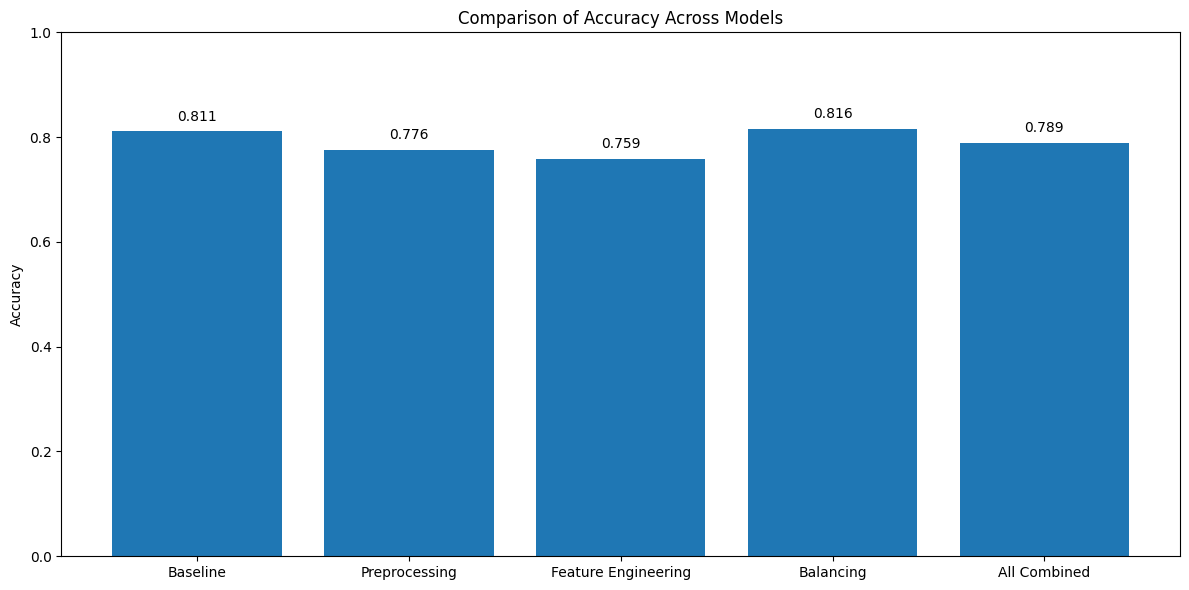

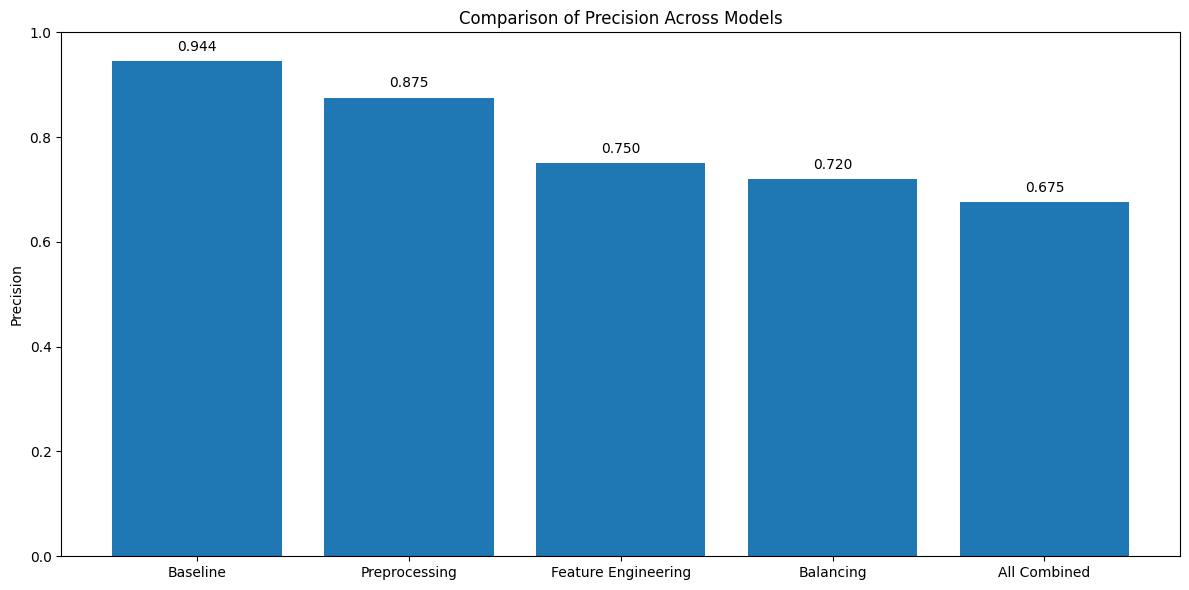

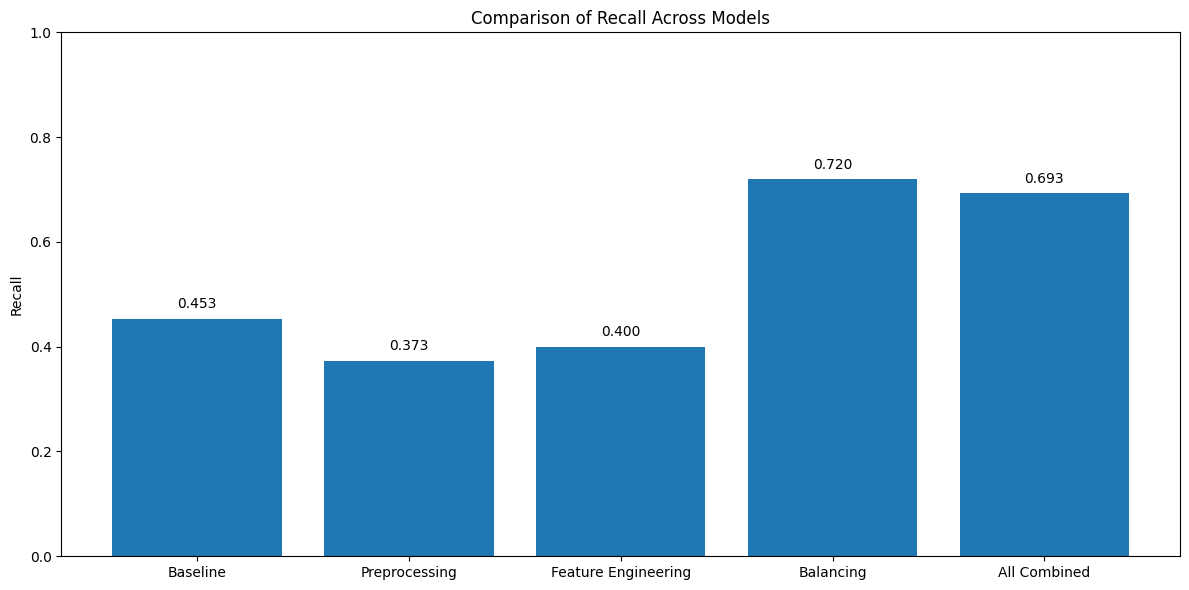

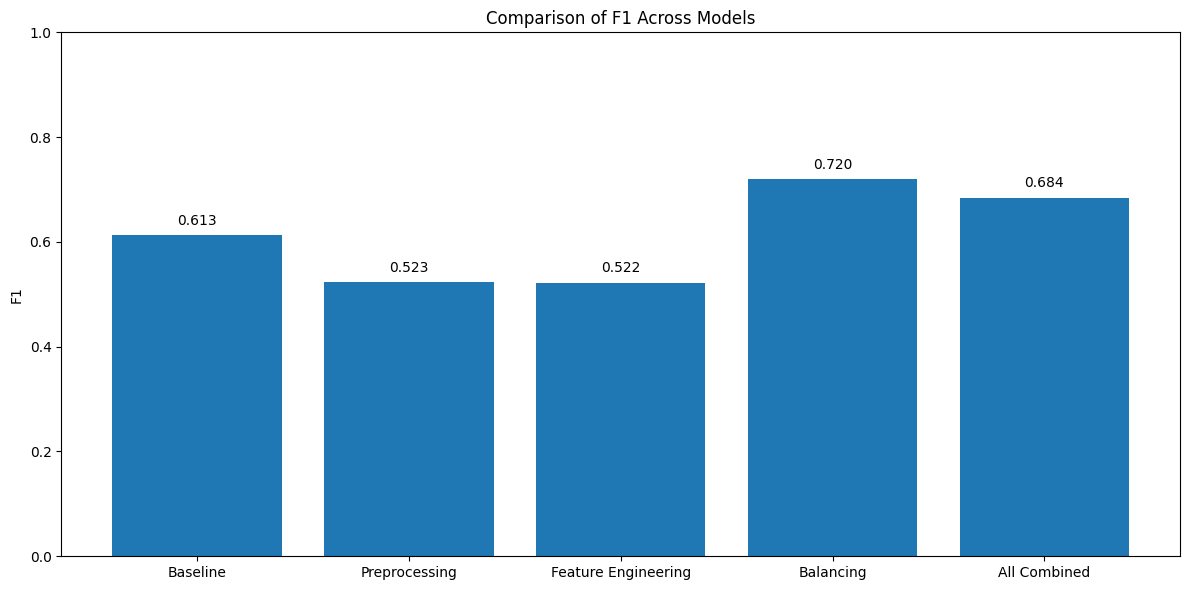

In [ ]:
print("\n--- Experiment Results Comparison ---")
methods = list(results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1']

for metric in metrics:
    plt.figure(figsize=(12, 6))
    values = [results[method][metric] for method in methods]
    plt.bar(methods, values)
    plt.title(f'Comparison of {metric.capitalize()} Across Models')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1)

    # Add value labels
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f'{v:.3f}', ha='center')

    plt.tight_layout()

    # Display the plot in the notebook
    plt.show()

    # Save the plot if needed
    plt.savefig(f'comparison_{metric}.png')
    plt.close()

4.9- FInal Summary

In [ ]:
print("\n--- Final Summary ---")
best_model = max(results.items(), key=lambda x: x[1]['f1'])
print(f"Best model based on F1 score: {best_model[0]} with F1 = {best_model[1]['f1']:.4f}")

print("\nModel performance summary:")
for method, metrics in results.items():
    print(f"{method}: Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}")


--- Final Summary ---
Best model based on F1 score: Balancing with F1 = 0.7200

Model performance summary:
Baseline: Accuracy=0.8114, F1=0.6126
Preprocessing: Accuracy=0.7763, F1=0.5234
Feature Engineering: Accuracy=0.7588, F1=0.5217
Balancing: Accuracy=0.8158, F1=0.7200
All Combined: Accuracy=0.7895, F1=0.6842


#5- Classification multi-classe (2 catégories) : {CLAIM, REF} vs. {CONTEXT} (pour SCI)

In [ ]:
# 1. Load the dataset
print("Loading dataset...")
try:
    df = pd.read_csv('scitweets_export.tsv', sep='\t')
except FileNotFoundError:
    print("Dataset file not found. Please ensure 'scitweets_export.tsv' is in the correct location.")
    exit(1)

print(f"Dataset loaded: {df.shape[0]} rows and {df.shape[1]} columns")
print("Sample data:")
print(df.head())

# 2. Filtering only scientific tweets
scientific_df = df[df['science_related'] == 1].copy()
print(f"\nFiltered to {scientific_df.shape[0]} scientific tweets.")

# 3. creating binary target: CLAIM/REF (1) vs CONTEXT (0)
scientific_df['is_claim_or_ref'] = ((scientific_df['scientific_claim'] == 1) |
                                    (scientific_df['scientific_reference'] == 1)).astype(int)
scientific_df['is_context'] = (scientific_df['scientific_context'] == 1).astype(int)

# checking for potential conflicts (tweets marked as both claim/ref AND context)
conflicts = scientific_df[(scientific_df['is_claim_or_ref'] == 1) & (scientific_df['is_context'] == 1)]
print(f"Found {len(conflicts)} tweets marked as both CLAIM/REF and CONTEXT.")

# Creating final target variable
target_col = 'is_claim_or_ref'
print(f"\nTarget variable '{target_col}' distribution:")
original_class_counts = check_class_distribution(scientific_df[target_col])
plot_class_distribution(original_class_counts, "Original Dataset Class Distribution")

# 4. Preparing for different experiments
X = scientific_df['text']
y = scientific_df[target_col]

# Splitting data once to ensure consistent evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nSplit data into training ({len(X_train)} samples) and testing ({len(X_test)} samples) sets.")

# storing results for comparison
results = {}

Loading dataset...
Dataset loaded: 1140 rows and 7 columns
Sample data:
   Unnamed: 0            tweet_id  \
0           0  316669998137483264   
1           1  319090866545385472   
2           2  322030931022065664   
3           3  322694830620807168   
4           4  328524426658328576   

                                                text  science_related  \
0  Knees are a bit sore. i guess that's a sign th...                0   
1          McDonald's breakfast stop then the gym 🏀💪                0   
2  Can any Gynecologist with Cancer Experience ex...                1   
3  Couch-lock highs lead to sleeping in the couch...                1   
4  Does daily routine help prevent problems with ...                1   

   scientific_claim  scientific_reference  scientific_context  
0               0.0                   0.0                 0.0  
1               0.0                   0.0                 0.0  
2               1.0                   0.0                 0.0  
3         

##5.1- Experiment 1: Baseline with no preprocessing, feature engineering, or balancing


--- Experiment 1: Baseline Model ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


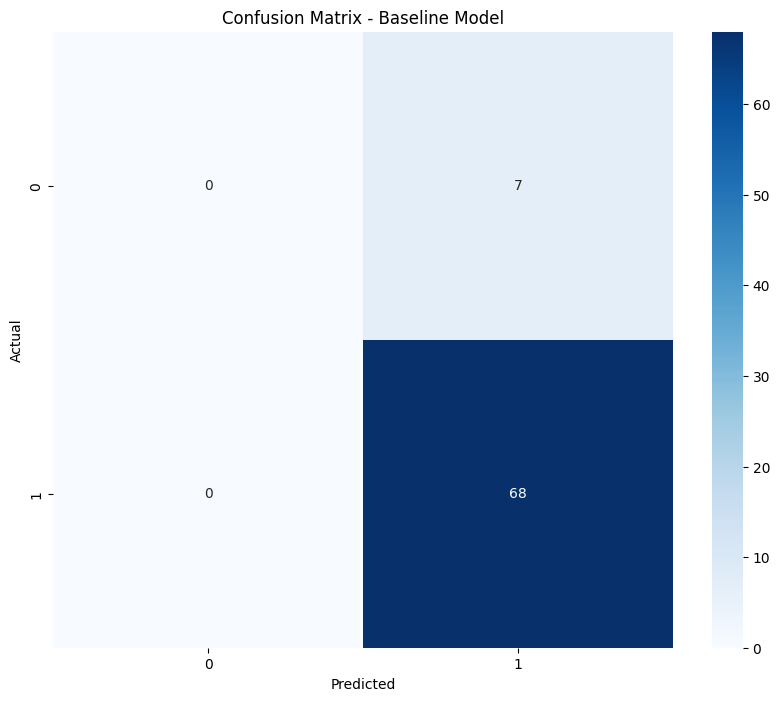


=== Baseline Model Performance ===
Accuracy: 0.9067
Precision: 0.9067
Recall: 1.0000
F1 Score: 0.9510

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      1.00      0.95        68

    accuracy                           0.91        75
   macro avg       0.45      0.50      0.48        75
weighted avg       0.82      0.91      0.86        75


Confusion Matrix:
[[ 0  7]
 [ 0 68]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("\n--- Experiment 1: Baseline Model ---")
# Simple TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train logistic regression model
model_baseline = LogisticRegression(max_iter=1000, random_state=42)
model_baseline.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_baseline = model_baseline.predict(X_test_tfidf)

# Display confusion matrix (similar to the first code)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred_baseline)
report = classification_report(y_test, y_pred_baseline)

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_baseline.classes_, yticklabels=model_baseline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Baseline Model')
plt.show()

# Store results
results['Baseline'] = evaluate_model(y_test, y_pred_baseline, "Baseline Model")

##5.2- Experiment 2: With text preprocessing only


--- Experiment 2: Preprocessing Only ---
Preprocessing texts...


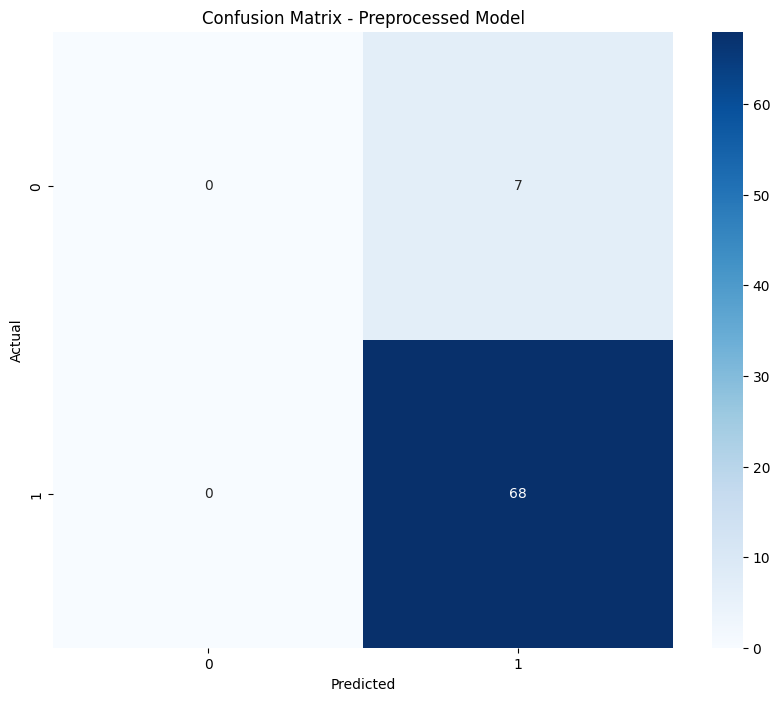


=== Preprocessed Model Performance ===
Accuracy: 0.9067
Precision: 0.9067
Recall: 1.0000
F1 Score: 0.9510

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      1.00      0.95        68

    accuracy                           0.91        75
   macro avg       0.45      0.50      0.48        75
weighted avg       0.82      0.91      0.86        75


Confusion Matrix:
[[ 0  7]
 [ 0 68]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("\n--- Experiment 2: Preprocessing Only ---")

# Preprocess data
print("Preprocessing texts...")
df_train_processed = preprocess_dataset(pd.DataFrame({'text': X_train}))
df_test_processed = preprocess_dataset(pd.DataFrame({'text': X_test}))

# TF-IDF on preprocessed text
tfidf_preprocessed = TfidfVectorizer(max_features=1000)
X_train_tfidf_prep = tfidf_preprocessed.fit_transform(df_train_processed['text_processed'])
X_test_tfidf_prep = tfidf_preprocessed.transform(df_test_processed['text_processed'])

# Train logistic regression
model_preprocessed = LogisticRegression(max_iter=1000, random_state=42)
model_preprocessed.fit(X_train_tfidf_prep, y_train)

# Evaluate
y_pred_preprocessed = model_preprocessed.predict(X_test_tfidf_prep)

# Display confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_preprocessed)

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred_preprocessed)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_preprocessed.classes_, yticklabels=model_preprocessed.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Preprocessed Model')
plt.show()

# Store results
results['Preprocessing'] = evaluate_model(y_test, y_pred_preprocessed, "Preprocessed Model")

##5.3- Experiment 3: With feature engineering only


--- Experiment 3: Feature Engineering Only ---
Extracting features...


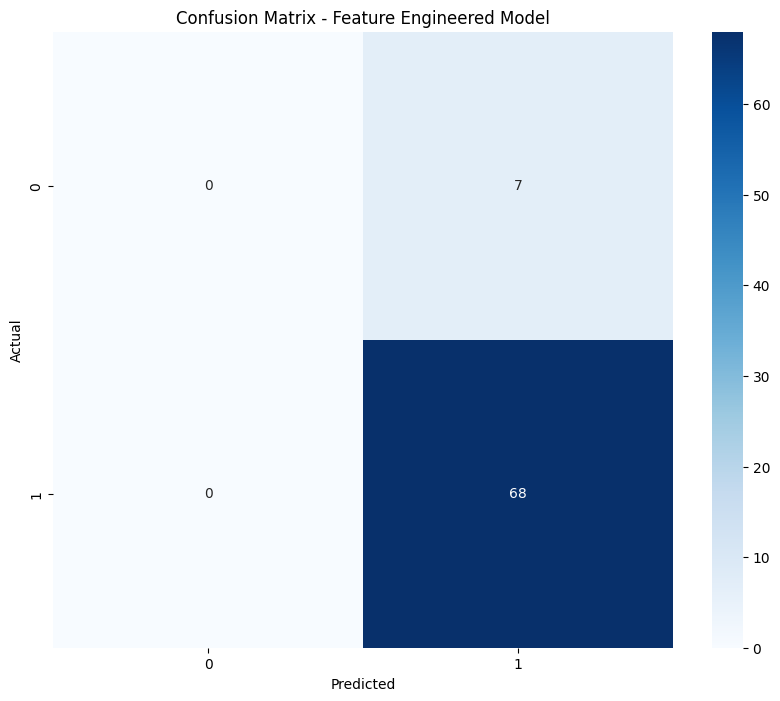


=== Feature Engineered Model Performance ===
Accuracy: 0.9067
Precision: 0.9067
Recall: 1.0000
F1 Score: 0.9510

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      1.00      0.95        68

    accuracy                           0.91        75
   macro avg       0.45      0.50      0.48        75
weighted avg       0.82      0.91      0.86        75


Confusion Matrix:
[[ 0  7]
 [ 0 68]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("\n--- Experiment 3: Feature Engineering Only ---")

# Create feature-engineered datasets
print("Extracting features...")
df_train_features = extract_basic_features(pd.DataFrame({'text': X_train}))
df_test_features = extract_basic_features(pd.DataFrame({'text': X_test}))

# Drop text column to keep only numeric features
feature_cols = [col for col in df_train_features.columns if col != 'text']
X_train_features = df_train_features[feature_cols]
X_test_features = df_test_features[feature_cols]

# Train logistic regression
model_features = LogisticRegression(max_iter=1000, random_state=42)
model_features.fit(X_train_features, y_train)

# Evaluate
y_pred_features = model_features.predict(X_test_features)

# Display confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_features)

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred_features)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_features.classes_, yticklabels=model_features.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Feature Engineered Model')
plt.show()

# Store results
results['Feature Engineering'] = evaluate_model(y_test, y_pred_features, "Feature Engineered Model")

##5.4- Experiment 4: With balancing only


--- Experiment 4: Balancing Only ---
Applying smote balancing...
Original dataset shape: Counter({1: 274, 0: 26})
Resampled dataset shape: Counter({1: 274, 0: 274})


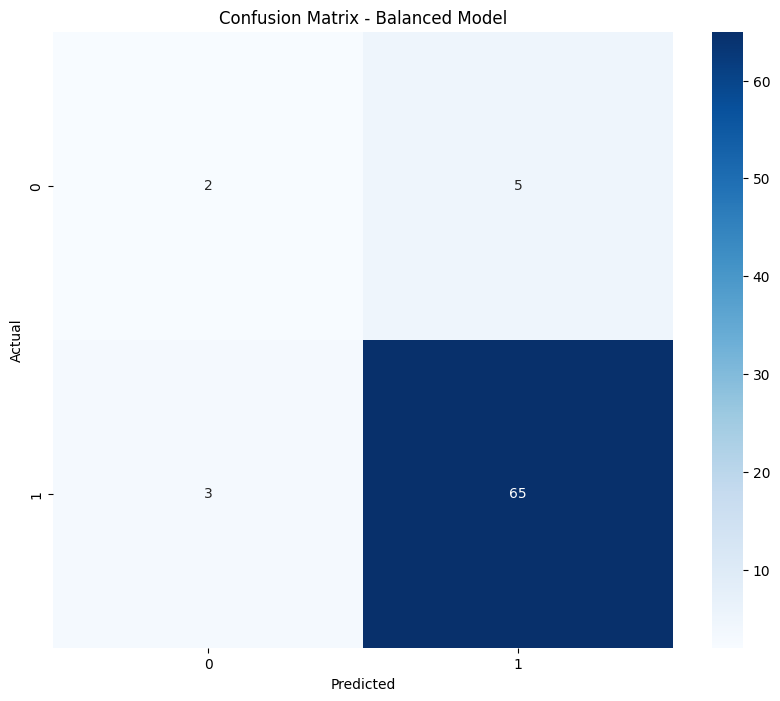


=== Balanced Model Performance ===
Accuracy: 0.8933
Precision: 0.9286
Recall: 0.9559
F1 Score: 0.9420

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.29      0.33         7
           1       0.93      0.96      0.94        68

    accuracy                           0.89        75
   macro avg       0.66      0.62      0.64        75
weighted avg       0.88      0.89      0.89        75


Confusion Matrix:
[[ 2  5]
 [ 3 65]]


In [ ]:
print("\n--- Experiment 4: Balancing Only ---")

# Apply SMOTE balancing on TF-IDF features
X_train_tfidf_balanced, y_train_balanced = apply_data_balancing(
    X_train_tfidf.toarray(), y_train, method='smote', random_state=42
)

# Train
model_balanced = LogisticRegression(max_iter=1000, random_state=42)
model_balanced.fit(X_train_tfidf_balanced, y_train_balanced)

# Evaluate
y_pred_balanced = model_balanced.predict(X_test_tfidf)

# Display confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_balanced)

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred_balanced)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_balanced.classes_, yticklabels=model_balanced.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Balanced Model')
plt.show()

# Store results
results['Balancing'] = evaluate_model(y_test, y_pred_balanced, "Balanced Model")

##5.5- Experiment 5: With all techniques combined


--- Experiment 5: All Techniques Combined ---
Combining all techniques...
Applying smote balancing...
Original dataset shape: Counter({1: 274, 0: 26})
Resampled dataset shape: Counter({1: 274, 0: 274})


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


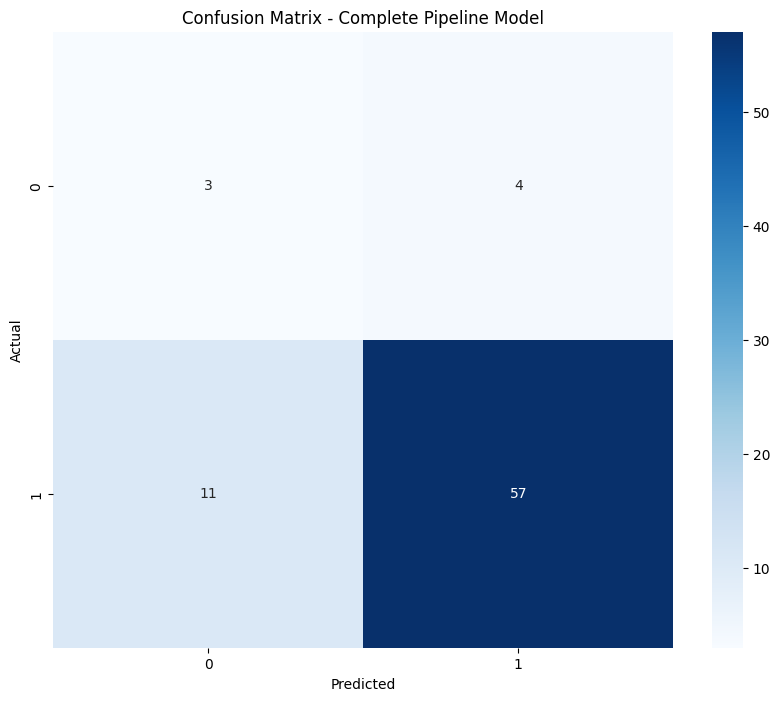


=== Complete Pipeline Model Performance ===
Accuracy: 0.8000
Precision: 0.9344
Recall: 0.8382
F1 Score: 0.8837

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.43      0.29         7
           1       0.93      0.84      0.88        68

    accuracy                           0.80        75
   macro avg       0.57      0.63      0.58        75
weighted avg       0.87      0.80      0.83        75


Confusion Matrix:
[[ 3  4]
 [11 57]]


In [ ]:
print("\n--- Experiment 5: All Techniques Combined ---")

# Preprocess + Feature Engineering
print("Combining all techniques...")

# First preprocess
df_train_processed = preprocess_dataset(pd.DataFrame({'text': X_train}))
df_test_processed = preprocess_dataset(pd.DataFrame({'text': X_test}))

# Then apply feature engineering
df_train_all, train_vectorizer = feature_engineering_pipeline(df_train_processed, text_column='text_processed')

# For test set, use the vectorizer from training
df_test_all = extract_basic_features(df_test_processed, text_column='text_processed')
test_tfidf_features = train_vectorizer.transform(df_test_processed['text_processed'])

# Add TF-IDF features to test dataframe
tfidf_test_df = pd.DataFrame(
    test_tfidf_features.toarray(),
    columns=[f'tfidf_{i}' for i in range(test_tfidf_features.shape[1])],
    index=df_test_all.index
)
df_test_all = pd.concat([df_test_all, tfidf_test_df], axis=1)

# Drop text columns
feature_cols = [col for col in df_train_all.columns
               if col not in ['text', 'text_processed']]
X_train_all = df_train_all[feature_cols]
X_test_all = df_test_all[feature_cols]

# Apply balancing
X_train_all_balanced, y_train_all_balanced = apply_data_balancing(
    X_train_all.values, y_train, method='smote', random_state=42
)

# Train logistic regression
model_all = LogisticRegression(max_iter=1000, random_state=42)
model_all.fit(X_train_all_balanced, y_train_all_balanced)

# Evaluate
y_pred_all = model_all.predict(X_test_all)

# Display confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_all)

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred_all)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_all.classes_, yticklabels=model_all.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Complete Pipeline Model')
plt.show()

# Store results
results['All Combined'] = evaluate_model(y_test, y_pred_all, "Complete Pipeline Model")

##5.6- Compare all results

In [ ]:
print("\n--- Experiment Results Comparison ---")
methods = list(results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1']

for metric in metrics:
    plt.figure(figsize=(12, 6))
    values = [results[method][metric] for method in methods]
    plt.bar(methods, values)
    plt.title(f'Comparison of {metric.capitalize()} Across Models')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1)

    # Add value labels
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.savefig(f'comparison_{metric}_claim_ref_vs_context.png')
    plt.close()


--- Experiment Results Comparison ---


##5.7- Test prediction on new texts

In [ ]:
print("\n--- Testing Prediction on New Texts ---")

# Sample texts for testing
claim_text = "Our new study demonstrates that antioxidants can slow cellular aging in laboratory conditions."
ref_text = "According to recent research published in Nature, climate change is accelerating at a rate faster than previously predicted."
context_text = "Scientists have been studying cellular aging for decades using various methodologies and approaches."

# Predict using the best model
print("\nPredicting with the Complete Pipeline Model:")

for sample_text, expected_category in [
    (claim_text, "CLAIM/REF"),
    (ref_text, "CLAIM/REF"),
    (context_text, "CONTEXT")
]:
    # Preprocess
    processed_text = preprocess_text(sample_text)
    sample_df = pd.DataFrame({'text': [sample_text], 'text_processed': [processed_text]})
    sample_features = extract_basic_features(sample_df, text_column='text_processed')
    sample_tfidf = train_vectorizer.transform([processed_text])

    # Add TF-IDF features
    sample_tfidf_df = pd.DataFrame(
        sample_tfidf.toarray(),
        columns=[f'tfidf_{i}' for i in range(sample_tfidf.shape[1])],
        index=sample_features.index
    )
    sample_features = pd.concat([sample_features, sample_tfidf_df], axis=1)

    # Drop text columns
    feature_cols = [col for col in sample_features.columns
                   if col not in ['text', 'text_processed']]
    sample_features_final = sample_features[feature_cols]

    # Predict
    prediction = model_all.predict(sample_features_final)[0]
    probability = model_all.predict_proba(sample_features_final)[0][1]
    category = "CLAIM/REF" if prediction == 1 else "CONTEXT"

    print(f"\nText: '{sample_text}'")
    print(f"Expected category: {expected_category}")
    print(f"Predicted category: {category}")
    print(f"Probability of being CLAIM/REF: {probability:.2f}")


--- Testing Prediction on New Texts ---

Predicting with the Complete Pipeline Model:

Text: 'Our new study demonstrates that antioxidants can slow cellular aging in laboratory conditions.'
Expected category: CLAIM/REF
Predicted category: CLAIM/REF
Probability of being CLAIM/REF: 0.79

Text: 'According to recent research published in Nature, climate change is accelerating at a rate faster than previously predicted.'
Expected category: CLAIM/REF
Predicted category: CLAIM/REF
Probability of being CLAIM/REF: 0.52

Text: 'Scientists have been studying cellular aging for decades using various methodologies and approaches.'
Expected category: CONTEXT
Predicted category: CLAIM/REF
Probability of being CLAIM/REF: 0.77


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has fe

##5.8- Final Summary

In [ ]:
print("\n--- Final Summary ---")
best_model = max(results.items(), key=lambda x: x[1]['f1'])
print(f"Best model based on F1 score: {best_model[0]} with F1 = {best_model[1]['f1']:.4f}")

print("\nModel performance summary:")
for method, metrics in results.items():
    print(f"{method}: Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}")


--- Final Summary ---
Best model based on F1 score: Baseline with F1 = 0.9510

Model performance summary:
Baseline: Accuracy=0.9067, F1=0.9510
Preprocessing: Accuracy=0.9067, F1=0.9510
Feature Engineering: Accuracy=0.9067, F1=0.9510
Balancing: Accuracy=0.8933, F1=0.9420
All Combined: Accuracy=0.8000, F1=0.8837


#6- Classification multi-classe (3 catégories) : {CLAIM} vs. {REF} vs. {CONTEXT} (pour SCI)

In [ ]:
def load_and_prepare_data(file_path):
    """Load dataset and prepare for classification."""
    print("Loading and preparing data...")

    # Load the dataset
    df = pd.read_csv(file_path, sep='\t')

    # Map the target columns to a single category
    def map_to_category(row):
        if row['scientific_claim'] == 1:
            return 'CLAIM'
        elif row['scientific_reference'] == 1:
            return 'REF'
        elif row['scientific_context'] == 1:
            return 'CONTEXT'
        else:
            return 'OTHER'  # For non-scientific tweets

    # Create the target column
    df['category'] = df.apply(map_to_category, axis=1)

    # Filter to keep only scientific tweets (CLAIM, REF, CONTEXT)
    df_scientific = df[df['science_related'] == 1]

    # Check distribution
    print("Category distribution:")
    print(df_scientific['category'].value_counts())

    return df_scientific


In [ ]:
# Load the data
file_path = 'scitweets_export.tsv'  # Update this path as needed
df = load_and_prepare_data(file_path)

# 3. Model Training and Evaluation Function
def train_and_evaluate_model(X_train, X_test, y_train, y_test, class_weights=None):
    """Train and evaluate a logistic regression model."""
    # Create and train the model
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        class_weight=class_weights,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_,
                yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return model, accuracy, report, y_pred

Loading and preparing data...
Category distribution:
category
CLAIM      263
REF         79
CONTEXT     33
Name: count, dtype: int64


##6.1- Baseline Classification (No preprocessing, feature engineering, or balancing)


=== BASELINE CLASSIFICATION ===
Accuracy: 0.7080
Classification Report:
              precision    recall  f1-score   support

       CLAIM       0.74      0.92      0.82        79
     CONTEXT       0.67      0.20      0.31        10
         REF       0.42      0.21      0.28        24

    accuracy                           0.71       113
   macro avg       0.61      0.44      0.47       113
weighted avg       0.67      0.71      0.66       113



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


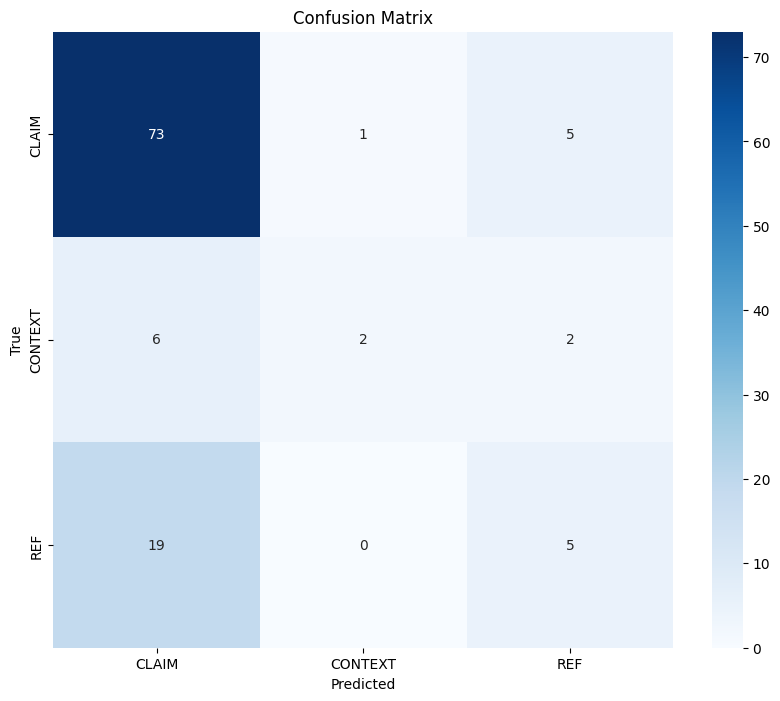

In [ ]:
def baseline_classification(df, text_column='text'):
    """Baseline classification without any preprocessing, feature engineering or balancing."""
    print("\n=== BASELINE CLASSIFICATION ===")

    # Split data
    X = df[text_column].values
    y = df['category'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Create features using simple CountVectorizer
    vectorizer = CountVectorizer(max_features=1000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Train and evaluate
    model, accuracy, report, _ = train_and_evaluate_model(
        X_train_vec, X_test_vec, y_train, y_test
    )

    return {
        'model': model,
        'vectorizer': vectorizer,
        'accuracy': accuracy,
        'report': report
    }
    # Run baseline classification
baseline_results = baseline_classification(df)

##6.2- Text Preprocessing Only Classification


=== PREPROCESSING ONLY CLASSIFICATION ===


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.7345
Classification Report:
              precision    recall  f1-score   support

       CLAIM       0.75      0.96      0.84        79
     CONTEXT       0.75      0.30      0.43        10
         REF       0.57      0.17      0.26        24

    accuracy                           0.73       113
   macro avg       0.69      0.48      0.51       113
weighted avg       0.71      0.73      0.68       113



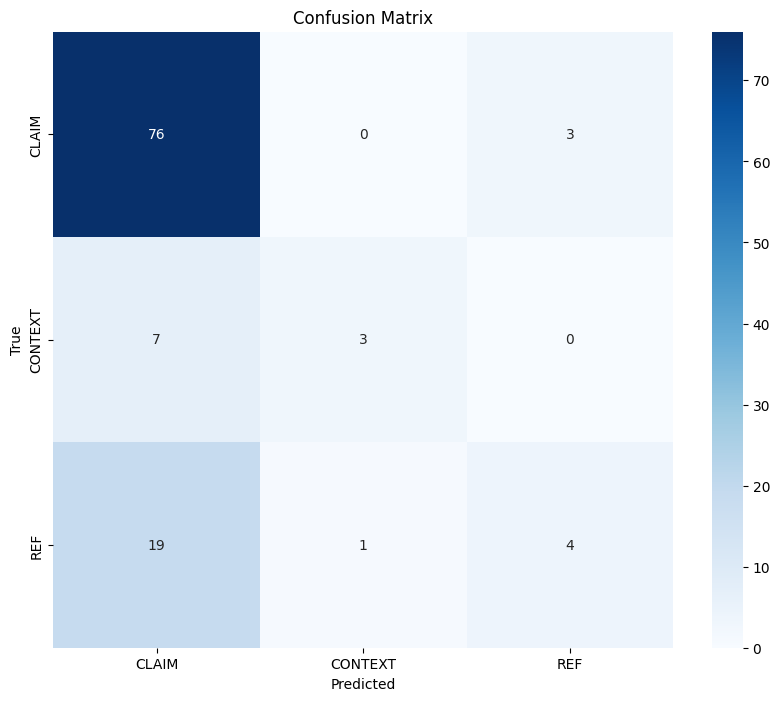

In [ ]:
def preprocessing_only_classification(df, text_column='text'):
    """Classification with text preprocessing only."""
    print("\n=== PREPROCESSING ONLY CLASSIFICATION ===")

    # Preprocess text
    df_processed = preprocess_dataset(df, text_column)

    # Split data
    X = df_processed['text_processed'].values
    y = df_processed['category'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Create features using CountVectorizer
    vectorizer = CountVectorizer(max_features=1000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Train and evaluate
    model, accuracy, report, _ = train_and_evaluate_model(
        X_train_vec, X_test_vec, y_train, y_test
    )

    return {
        'model': model,
        'vectorizer': vectorizer,
        'accuracy': accuracy,
        'report': report
    }

# Run preprocessing only classification
preprocessing_results = preprocessing_only_classification(df)

##6.3- Feature Engineering Only Classification


=== FEATURE ENGINEERING ONLY CLASSIFICATION ===


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: 

Accuracy: 0.6991
Classification Report:
              precision    recall  f1-score   support

       CLAIM       0.70      1.00      0.82        79
     CONTEXT       0.00      0.00      0.00        10
         REF       0.00      0.00      0.00        24

    accuracy                           0.70       113
   macro avg       0.23      0.33      0.27       113
weighted avg       0.49      0.70      0.58       113



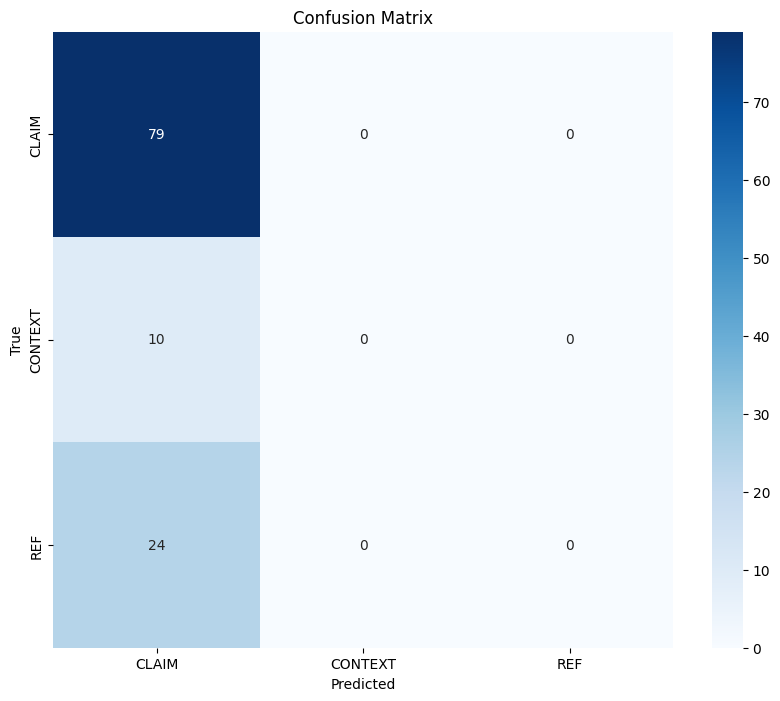

In [ ]:
def feature_engineering_only_classification(df, text_column='text'):
    """Classification with feature engineering only."""
    print("\n=== FEATURE ENGINEERING ONLY CLASSIFICATION ===")

    # Extract features
    df_features, vectorizer = feature_engineering_pipeline(df, text_column)

    # Prepare feature matrix (exclude text columns and target)
    feature_cols = [col for col in df_features.columns if col not in
                   [text_column, 'category', 'text_processed']]

    # Split data
    X = df_features[feature_cols].values
    y = df_features['category'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Train and evaluate
    model, accuracy, report, _ = train_and_evaluate_model(
        X_train, X_test, y_train, y_test
    )

    return {
        'model': model,
        'features': feature_cols,
        'accuracy': accuracy,
        'report': report
    }

# Run feature engineering only classification
feature_eng_results = feature_engineering_only_classification(df)

##6.4- Balancing Only Classification


=== BALANCING ONLY CLASSIFICATION ===
Applying smote balancing...
Original dataset shape: Counter({'CLAIM': 184, 'REF': 55, 'CONTEXT': 23})
Resampled dataset shape: Counter({'REF': 184, 'CLAIM': 184, 'CONTEXT': 184})
Accuracy: 0.6195
Classification Report:
              precision    recall  f1-score   support

       CLAIM       0.85      0.70      0.76        79
     CONTEXT       0.25      0.60      0.35        10
         REF       0.38      0.38      0.38        24

    accuracy                           0.62       113
   macro avg       0.49      0.56      0.50       113
weighted avg       0.69      0.62      0.64       113



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


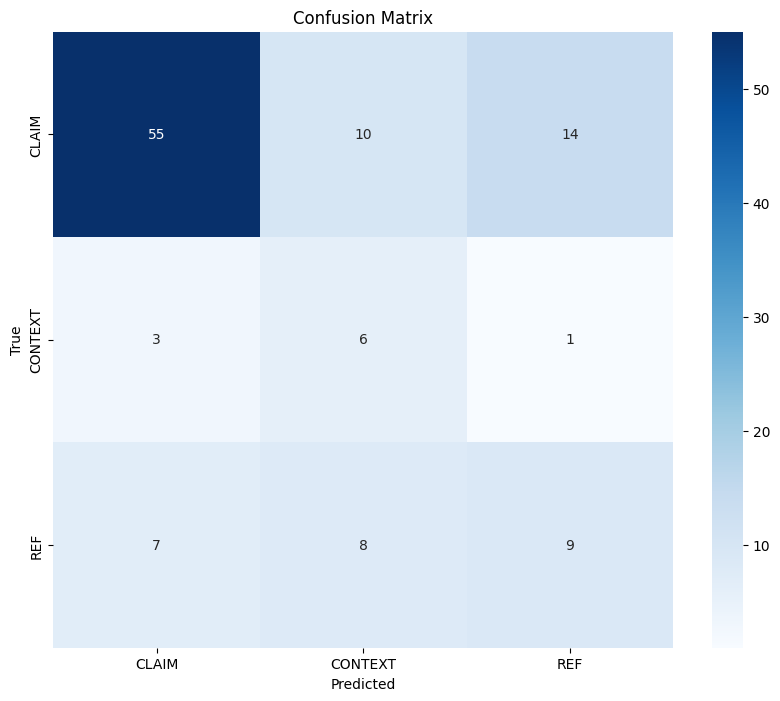

In [ ]:
def balancing_only_classification(df, text_column='text'):
    """Classification with data balancing only."""
    print("\n=== BALANCING ONLY CLASSIFICATION ===")

    # Split data first
    X_text = df[text_column].values
    y = df['category'].values
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        X_text, y, test_size=0.3, random_state=42, stratify=y
    )

    # Create features using CountVectorizer
    vectorizer = CountVectorizer(max_features=1000)
    X_train_vec = vectorizer.fit_transform(X_train_text)
    X_test_vec = vectorizer.transform(X_test_text)

    # Apply balancing to training data
    X_train_balanced, y_train_balanced = apply_data_balancing(
        X_train_vec, y_train, method='smote'
    )

    # Train and evaluate
    model, accuracy, report, _ = train_and_evaluate_model(
        X_train_balanced, X_test_vec, y_train_balanced, y_test
    )

    return {
        'model': model,
        'vectorizer': vectorizer,
        'accuracy': accuracy,
        'report': report
    }

# Run balancing only classification
balancing_results = balancing_only_classification(df)


##6.5- Combined Approach Classification


=== COMBINED APPROACH CLASSIFICATION ===
Applying smote balancing...
Original dataset shape: Counter({'CLAIM': 184, 'REF': 55, 'CONTEXT': 23})
Resampled dataset shape: Counter({'REF': 184, 'CLAIM': 184, 'CONTEXT': 184})
Accuracy: 0.0885
Classification Report:
              precision    recall  f1-score   support

       CLAIM       0.00      0.00      0.00        79
     CONTEXT       0.09      1.00      0.16        10
         REF       0.00      0.00      0.00        24

    accuracy                           0.09       113
   macro avg       0.03      0.33      0.05       113
weighted avg       0.01      0.09      0.01       113



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: 

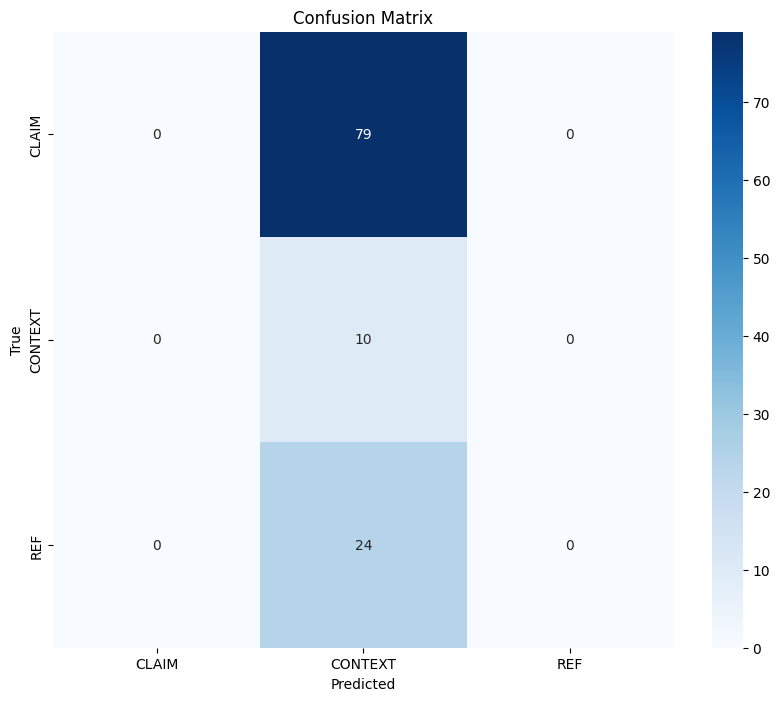

In [ ]:
def combined_approach_classification(df, text_column='text'):
    """Classification with preprocessing, feature engineering, and balancing."""
    print("\n=== COMBINED APPROACH CLASSIFICATION ===")

    # 1. Preprocess text
    df_processed = preprocess_dataset(df, text_column)

    # 2. Extract features
    df_features, vectorizer = feature_engineering_pipeline(
        df_processed, 'text_processed'
    )

    # Prepare feature matrix
    feature_cols = [col for col in df_features.columns if col not in
                   [text_column, 'category', 'text_processed']]

    # Split data
    X = df_features[feature_cols].values
    y = df_features['category'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 3. Apply balancing to training data
    X_train_balanced, y_train_balanced = apply_data_balancing(
        X_train, y_train, method='smote'
    )

    # Train and evaluate
    model, accuracy, report, _ = train_and_evaluate_model(
        X_train_balanced, X_test, y_train_balanced, y_test
    )

    return {
        'model': model,
        'features': feature_cols,
        'accuracy': accuracy,
        'report': report
    }

# Run combined approach classification
combined_results = combined_approach_classification(df)


##6.6- Comparison

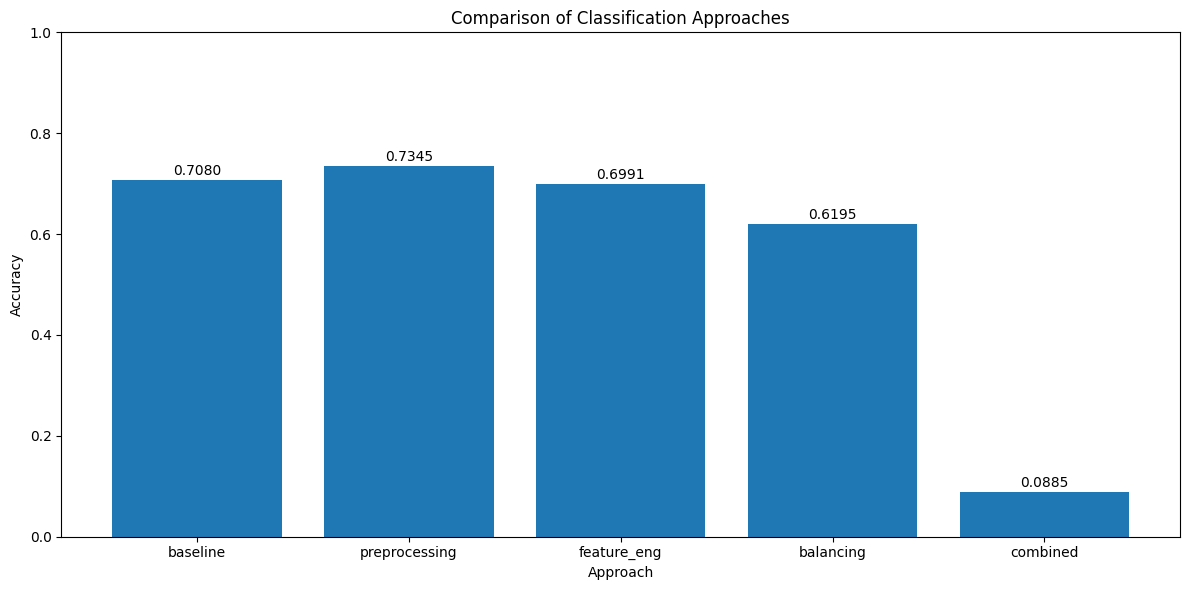


=== CLASSIFICATION RESULTS SUMMARY ===
Approach		Accuracy
----------------------------------------
baseline            	0.7080
preprocessing       	0.7345
feature_eng         	0.6991
balancing           	0.6195
combined            	0.0885


In [ ]:
def compare_results(results):
    """Compare and visualize results from different approaches."""
    approaches = list(results.keys())
    accuracies = [results[approach]['accuracy'] for approach in approaches]

    # Plot accuracies
    plt.figure(figsize=(12, 6))
    plt.bar(approaches, accuracies)
    plt.title('Comparison of Classification Approaches')
    plt.xlabel('Approach')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # Add accuracy values on bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n=== CLASSIFICATION RESULTS SUMMARY ===")
    print("Approach\t\tAccuracy")
    print("-" * 40)
    for approach in approaches:
        print(f"{approach.ljust(20)}\t{results[approach]['accuracy']:.4f}")

# Collect all results
all_results = {
    'baseline': baseline_results,
    'preprocessing': preprocessing_results,
    'feature_eng': feature_eng_results,
    'balancing': balancing_results,
    'combined': combined_results
}

# Compare all results
compare_results(all_results)

##6.7- Prediction

In [ ]:
def predict_category(text, model, vectorizer=None, preprocessor=None, feature_extractor=None):
    """Predict category for a new text."""
    if preprocessor:
        text = preprocessor(text)

    if vectorizer:
        # If using a vectorizer (bag-of-words or TF-IDF)
        X = vectorizer.transform([text])
    elif feature_extractor:
        # If using custom feature extraction
        features = feature_extractor(pd.DataFrame([{'text': text}]))
        X = features.iloc[0].values.reshape(1, -1)
    else:
        raise ValueError("Either vectorizer or feature_extractor must be provided")

    # Predict
    prediction = model.predict(X)[0]
    probabilities = model.predict_proba(X)[0]

    # Get class probabilities
    class_probs = {cls: prob for cls, prob in zip(model.classes_, probabilities)}

    return {
        'category': prediction,
        'probabilities': class_probs
    }

# Get the best model
best_approach = max(all_results, key=lambda k: all_results[k]['accuracy'])
best_model = all_results[best_approach]['model']
print(f"\nBest approach: {best_approach} with accuracy {all_results[best_approach]['accuracy']:.4f}")

# Example: Predict on new text
new_texts = [
    "A new study shows that drinking coffee may reduce risk of heart disease according to researchers.",
    "According to Dr. Smith's paper published in Nature, climate change is accelerating faster than expected.",
    "The scientific community is debating the implications of these findings for public health policy."
]

print("\n=== PREDICTIONS ON NEW TEXTS ===")

for i, text in enumerate(new_texts):
    # Use appropriate preprocessing/vectorization based on the best approach
    if best_approach == 'baseline':
        prediction = predict_category(
            text, best_model, vectorizer=all_results[best_approach]['vectorizer']
        )
    elif best_approach == 'preprocessing':
        prediction = predict_category(
            text, best_model,
            vectorizer=all_results[best_approach]['vectorizer'],
            preprocessor=preprocess_text
        )
    elif best_approach in ['feature_eng', 'combined']:
        # This is simplified - would need to create a function to extract features for single texts
        prediction = predict_category(
            text, best_model,
            vectorizer=all_results['baseline']['vectorizer']  # Fallback for demonstration
        )
    else:
        prediction = predict_category(
            text, best_model,
            vectorizer=all_results[best_approach]['vectorizer']
        )

    print(f"\nText {i+1}: {text}")
    print(f"Predicted category: {prediction['category']}")
    print("Probabilities:")
    for category, prob in prediction['probabilities'].items():
        print(f"  {category}: {prob:.4f}")



Best approach: preprocessing with accuracy 0.7345

=== PREDICTIONS ON NEW TEXTS ===

Text 1: A new study shows that drinking coffee may reduce risk of heart disease according to researchers.
Predicted category: CLAIM
Probabilities:
  CLAIM: 0.9009
  CONTEXT: 0.0078
  REF: 0.0912

Text 2: According to Dr. Smith's paper published in Nature, climate change is accelerating faster than expected.
Predicted category: REF
Probabilities:
  CLAIM: 0.3480
  CONTEXT: 0.0702
  REF: 0.5818

Text 3: The scientific community is debating the implications of these findings for public health policy.
Predicted category: CLAIM
Probabilities:
  CLAIM: 0.5805
  CONTEXT: 0.1574
  REF: 0.2620
